## Import packages

In [277]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [22]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [629]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

### Make Aaron's AHT data

In [373]:
one_file = scipy.io.loadmat('../aaron_aht_stuff/monthly_AHT/1980_1_AHT.mat')
aaron_lat = one_file['lat'].flatten()

dataDir = "../aaron_aht_stuff/monthly_AHT/"

all_ahts = np.zeros((len(times), len(aaron_lat.flatten())))
all_ahts_dry = np.zeros((len(times), len(aaron_lat.flatten())))
all_ahts_moist = np.zeros((len(times), len(aaron_lat.flatten())))
all_ahts_pot = np.zeros((len(times), len(aaron_lat.flatten())))

all_tes = np.zeros((len(times), len(aaron_lat.flatten())))
all_tes_dry = np.zeros((len(times), len(aaron_lat.flatten())))
all_tes_moist = np.zeros((len(times), len(aaron_lat.flatten())))
all_tes_pot = np.zeros((len(times), len(aaron_lat.flatten())))

all_ses = np.zeros((len(times), len(aaron_lat.flatten())))
all_ses_dry = np.zeros((len(times), len(aaron_lat.flatten())))
all_ses_moist = np.zeros((len(times), len(aaron_lat.flatten())))
all_ses_pot = np.zeros((len(times), len(aaron_lat.flatten())))

all_mmcs = np.zeros((len(times), len(aaron_lat.flatten())))

for file in sorted(os.listdir(dataDir)) :
    
    year = file[:4]
    month = re.sub(r'[^0-9]', '', file[5:7])
    
    time_idx = (int(year) - 1980) * 12 + (int(month) -1)
    
    data = scipy.io.loadmat(dataDir+file)
    
    this_aht = data['AHT'].flatten()
    this_aht_dry = data['AHT_dry'].flatten()
    this_aht_moist = data['AHT_moist'].flatten()
    this_aht_pot = data['AHT_pot'].flatten()
    
    this_te = data['TE'].flatten()
    this_te_dry = data['TE_dry'].flatten()
    this_te_moist = data['TE_moist'].flatten()
    this_te_pot = data['TE_pot'].flatten()
    
    this_se = data['SE'].flatten()
    this_se_dry = data['SE_dry'].flatten()
    this_se_moist = data['SE_moist'].flatten()
    this_se_pot = data['SE_pot'].flatten()
    
    this_mmc = data['MME'].flatten()
    
    all_ahts[time_idx,:] = this_aht
    all_ahts_dry[time_idx,:] = this_aht_dry
    all_ahts_moist[time_idx,:] = this_aht_moist
    all_ahts_pot[time_idx,:] = this_aht_pot
    
    all_tes[time_idx,:] = this_te
    all_tes_dry[time_idx,:] = this_te_dry
    all_tes_moist[time_idx,:] = this_te_moist
    all_tes_pot[time_idx,:] = this_te_pot
    
    all_ses[time_idx,:] = this_se
    all_ses_dry[time_idx,:] = this_se_dry
    all_ses_moist[time_idx,:] = this_se_moist
    all_ses_pot[time_idx,:] = this_se_pot
    
    all_mmcs[time_idx,:] = this_mmc

all_mmcs_dry = all_ahts_dry - all_tes_dry - all_ses_dry
all_mmcs_moist = all_ahts_moist - all_tes_moist - all_ses_moist
all_mmcs_pot = all_ahts_pot - all_tes_pot - all_ses_pot

In [699]:

final_ds = xr.Dataset(
                        data_vars = dict(
                            total_aht=(['time', 'latitude'], all_ahts),
                            total_aht_dry=(['time', 'latitude'], all_ahts_dry),
                            total_aht_moist=(['time', 'latitude'], all_ahts_moist),
                            total_aht_pot=(['time', 'latitude'], all_ahts_pot),
                            total_aht_dry_pot=(['time', 'latitude'], all_ahts_dry + all_ahts_pot),
                            te_aht=(['time', 'latitude'], all_tes),
                            te_aht_dry=(['time', 'latitude'], all_tes_dry),
                            te_aht_moist=(['time', 'latitude'], all_tes_moist),
                            te_aht_pot=(['time', 'latitude'], all_tes_pot),
                            te_aht_dry_pot=(['time', 'latitude'], all_tes_dry + all_tes_pot),
                            se_aht=(['time', 'latitude'], all_ses),
                            se_aht_dry=(['time', 'latitude'], all_ses_dry),
                            se_aht_moist=(['time', 'latitude'], all_ses_moist),
                            se_aht_pot=(['time', 'latitude'], all_ses_pot),
                            se_aht_dry_pot=(['time', 'latitude'], all_ses_dry + all_ses_pot),
                            mmc_aht=(['time', 'latitude'], all_mmcs),
                            mmc_aht_dry=(['time', 'latitude'], all_mmcs_dry),
                            mmc_aht_moist=(['time', 'latitude'], all_mmcs_moist),
                            mmc_aht_pot=(['time', 'latitude'], all_mmcs_pot),
                            mmc_aht_dry_pot=(['time', 'latitude'], all_mmcs_dry + all_mmcs_pot),
                        ),
                        coords=dict(
                            time = times,
                            latitude=aaron_lat)
    )
    
#final_ds.to_netcdf('aaron_aht_data_through_2018_with_time.nc', mode='w')

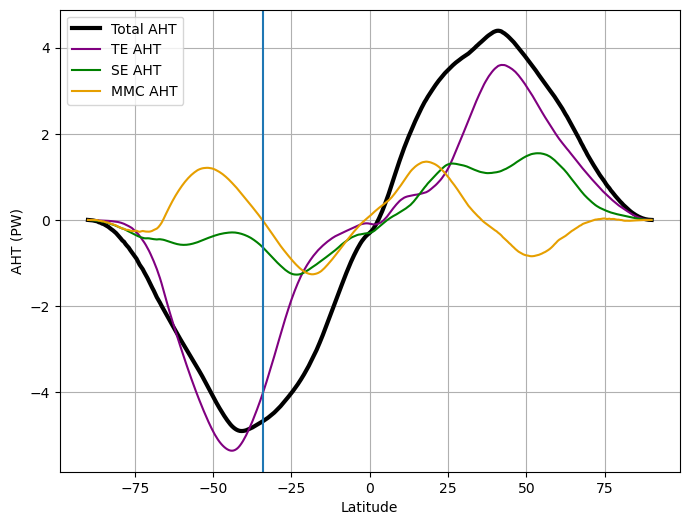

In [549]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_clima.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_clima.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, aht_clima.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')

plt.axvline(-34)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

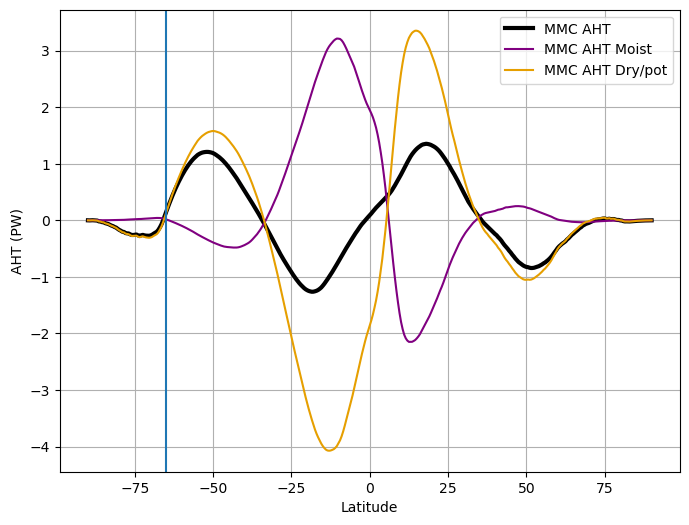

In [623]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.mmc_aht / 1e15, color='k', lw=3, label='MMC AHT')
plt.plot(lats, aht_clima.mmc_aht_moist / 1e15, color='purple', label='MMC AHT Moist')
plt.plot(lats, aht_clima.mmc_aht_dry_pot / 1e15, color='#E69F00', label='MMC AHT Dry/pot')

plt.axvline(-65)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

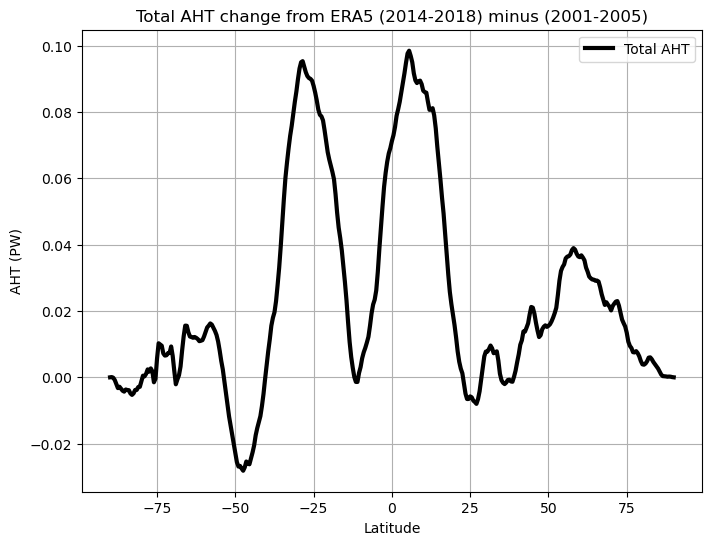

In [698]:
plt.figure(figsize=(8,6))

#aht_change = final_ds.sel(time=slice('2009-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('1980-01-01', '1989-12-31')).mean(['time'])
#For ceres only timeframe
aht_change = final_ds.sel(time=slice('2014-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('2001-01-01', '2005-12-31')).mean(['time'])


plt.plot(lats, aht_change.total_aht / 1e15, color='k', lw=3, label='Total AHT')
#plt.plot(lats, aht_change.te_aht / 1e15, color='purple', label='TE AHT')
#plt.plot(lats, aht_change.se_aht / 1e15, color='g', label='SE AHT')
#plt.plot(lats, aht_change.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')


#plt.plot(lats, aht_change.mmc_aht / 1e15, color='k', lw=3, label='Total')
#plt.plot(lats, aht_change.total_aht_dry / 1e15, color='r', lw=3, label='Dry AHT')
#plt.plot(lats, aht_change.mmc_aht_moist / 1e15, color='b', label='Moist AHT')
#plt.plot(lats, aht_change.total_aht_pot / 1e15, color='g', label='Pot AHT')
#plt.plot(lats, aht_change.mmc_aht_dry_pot / 1e15, color='g', label='Dry + Pot AHT')

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')
plt.title('Total AHT change from ERA5 (2014-2018) minus (2001-2005)')
#plt.savefig('../figures/5_24_22_meeting/aht_changes_era5_ceres_era')
plt.show()

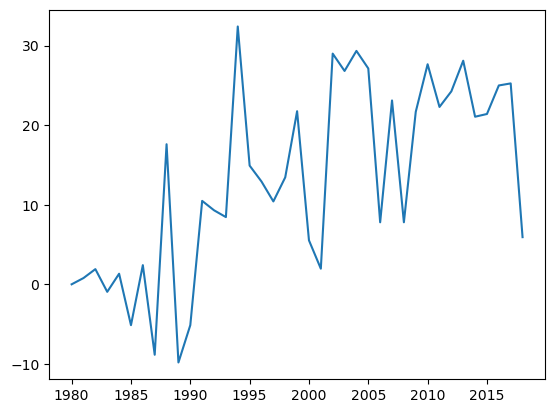

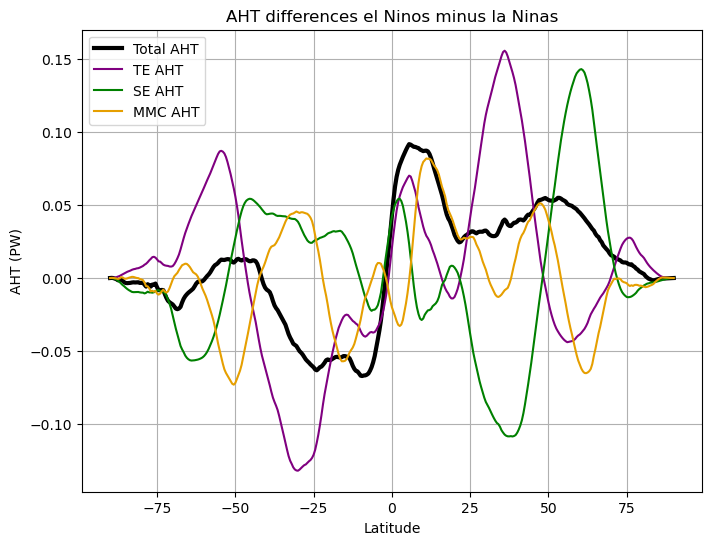

In [599]:
plt.figure(figsize=(8,6))

aht_variability = final_ds.groupby('time.year').mean(['time'])

years = range(1980, 2018)

el_ninos = [1982, 1983, 1987, 1988, 1992, 1993, 1997, 1998, 2002, 2003]

la_ninas = [1985, 1986, 1988, 1989, 1999, 2000, 2001, 2007, 2008, 2010, 2011]



aht_ninos = aht_variability.sel(year=el_ninos).mean(['year'])
aht_ninas = aht_variability.sel(year=la_ninas).mean(['year'])

enso_dif = aht_ninos - aht_ninas

plt.plot(lats, enso_dif.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, enso_dif.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, enso_dif.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, enso_dif.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

plt.title('AHT differences el Ninos minus la Ninas')

#plt.savefig('../figures/general_exam_plots/aht_changes_enso')
plt.show()

### Let's look at trends

In [385]:
def calc_autocorr(x):
    result = np.correlate(x, x, mode='full')
    result_valid_part = result[result.size // 2:]
    result_autocorr = result_valid_part / np.amax(result_valid_part)
    return result_autocorr

In [386]:
def find_trend(field):
    '''
    Finds the trend and other stuff
    '''
    
    time_space = range(len(field))
    lin_regress = sc.linregress(time_space, field)
    N = len(field)
    
    autocorr = calc_autocorr(field)[1]
    
    N_star = N * ((1 - autocorr) / (1 + autocorr))
    
    N = N_star
    
    if N < 3:
        N = 3
        
    else:
        pass
    
    
    lin_regress_predict = time_space * lin_regress.slope + lin_regress.intercept
    
    residuals = (field - lin_regress_predict) ** 2
    residuals_sum = np.sum(residuals)
    
    resids_err_var = N * (1 - lin_regress.rvalue ** 2) * np.mean((field - np.mean(field)) ** 2) / (N - 2)
    
    x_var = np.sum((time_space - np.mean(time_space)) ** 2) / N

    slope_err_var = resids_err_var / (N * x_var)

    intercept_err_var = residuals_sum / ((N - 2) * np.sum((time_space - np.mean(time_space)) ** 2))

    slope_std = slope_err_var ** 0.5
    intercept_std = intercept_err_var ** 0.5
    
    
    return lin_regress.slope, lin_regress.intercept, slope_std, intercept_std

In [387]:
slope_info = np.zeros((4, len(lats)))

for idx, lat in enumerate(lats):
    slope_info[:,idx] = find_trend(final_ds.total_aht.sel(latitude=lat).values/1e15)

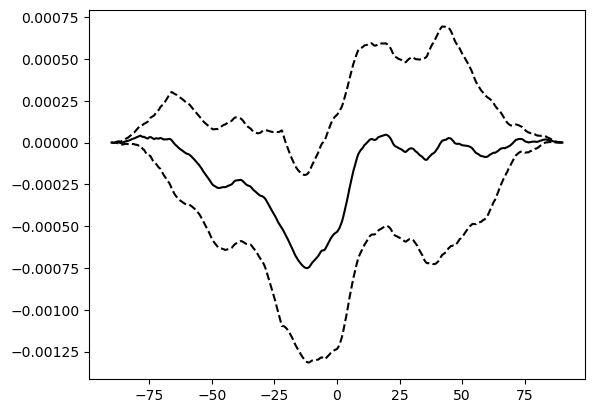

In [247]:
plt.plot(lats, slope_info[0,:], color='k')
plt.plot(lats, slope_info[0,:] + slope_info[2,:], '--', color='k')
plt.plot(lats, slope_info[0,:] - slope_info[2,:], '--', color='k')

plt.show()

In [234]:
which_field = final_ds.total_aht.sel(latitude=-45).values/1e15
#time_space = range((len(times)), len(times) * 2)
time_space = range(len(times))
lin_regress = sc.linregress(time_space, which_field)

N = len(which_field)

In [235]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result_valid_part = result[result.size // 2:]
    result_autocorr = result_valid_part / np.amax(result_valid_part)
    return result_autocorr

autocorr = autocorr(which_field)[1]

In [236]:
N_star = N * ((1 - autocorr) / (1 + autocorr))
N_star2 = N * np.log(autocorr) / 2
#N = N_star

In [241]:
np.log(autocorr)

-0.006487731144486005

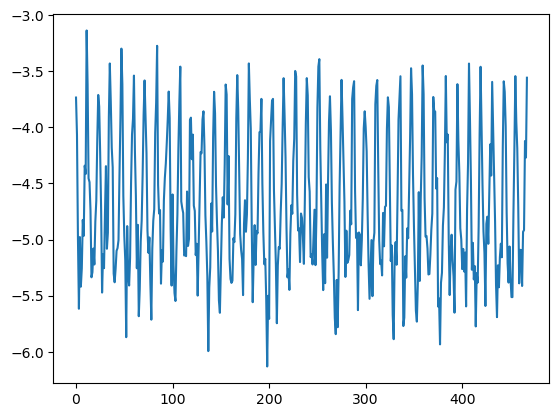

In [226]:
plt.plot(time_space, which_field)

plt.show()

In [227]:
lin_regress_predict = time_space * lin_regress.slope + lin_regress.intercept

In [228]:
residuals = (which_field - lin_regress_predict) ** 2
residuals_sum = np.sum(residuals)

In [229]:
resids_err_var = N * (1 - lin_regress.rvalue ** 2) * np.mean((which_field - np.mean(which_field)) ** 2) / (N - 2)

In [233]:
resids_err_var

-1.2466231131927032

In [230]:
x_var = np.sum((time_space - np.mean(time_space)) ** 2) / N

slope_err_var = resids_err_var / (N * x_var)

intercept_err_var = residuals_sum / ((N - 2) * np.sum((time_space - np.mean(time_space)) ** 2))

slope_std = slope_err_var ** 0.5
intercept_std = intercept_err_var ** 0.5
print(slope_std)
print(intercept_std)

nan
nan


<ipython-input-230-5262c4fa1883>:7: RuntimeWarning: invalid value encountered in double_scalars
  slope_std = slope_err_var ** 0.5
<ipython-input-230-5262c4fa1883>:8: RuntimeWarning: invalid value encountered in double_scalars
  intercept_std = intercept_err_var ** 0.5


In [231]:
print('Slopes are between: ' + str(lin_regress.slope - slope_std) + ' and ' + str(lin_regress.slope + slope_std))

Slopes are between: nan and nan


### Try just pulling random 10 year samples

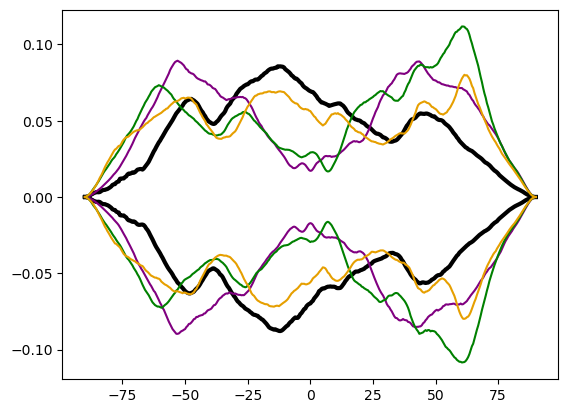

In [635]:
aht_variability = final_ds.groupby('time.year').mean(['time'])

aht_mean = aht_variability.mean(['year'])

num_samples = 10000
threshold = 0.95

years = range(1980, 2019)

total_ahts = np.zeros((len(lats), num_samples))
te_ahts = np.zeros((len(lats), num_samples))
se_ahts = np.zeros((len(lats), num_samples))
mmc_ahts = np.zeros((len(lats), num_samples))

for i in range(num_samples):
    
    random_years1 = random.sample(years, 10)
    random_years2 = random.sample(years, 10)
    
    aht_random_years1 = aht_variability.sel(year=random_years1).mean(['year'])
    aht_random_years2 = aht_variability.sel(year=random_years2).mean(['year'])
    
    aht_diff = aht_random_years1 - aht_random_years2
    
    total_aht = aht_diff.total_aht / 1e15
    te_aht = aht_diff.te_aht / 1e15
    se_aht = aht_diff.se_aht / 1e15
    mmc_aht = aht_diff.mmc_aht / 1e15
    
    total_ahts[:,i] = total_aht
    te_ahts[:,i] = te_aht
    se_ahts[:,i] = se_aht
    mmc_ahts[:,i] = mmc_aht
    
    #total_maxs = np.array([total_maxs,total_aht]).max(axis=0)
    #total_mins = np.array([total_mins,total_aht]).min(axis=0)
    #te_maxs = np.array([te_maxs,te_aht]).max(axis=0)
    #te_mins = np.array([te_mins,te_aht]).min(axis=0)
    #se_maxs = np.array([se_maxs,se_aht]).max(axis=0)
    #se_mins = np.array([se_mins,se_aht]).min(axis=0)
    #mmc_maxs = np.array([mmc_maxs,mmc_aht]).max(axis=0)
    #mmc_mins = np.array([mmc_mins,mmc_aht]).min(axis=0)
    
    #plt.plot(lats, total_aht, color='k', lw=3, label='Total AHT')
    #plt.plot(lats, te_aht, color='purple', label='TE AHT')
    #plt.plot(lats, se_aht, color='g', label='SE AHT')
    #plt.plot(lats, mmc_aht, color='#E69F00', label='MMC AHT')

total_maxs = np.zeros(len(lats))
total_mins = np.zeros(len(lats))
te_maxs = np.zeros(len(lats))
te_mins = np.zeros(len(lats))
se_maxs = np.zeros(len(lats))
se_mins = np.zeros(len(lats))
mmc_maxs = np.zeros(len(lats))
mmc_mins = np.zeros(len(lats))

for i in range(len(lats)):
    
    total_aht_one_lat = total_ahts[i,:]
    sorted_total_aht = np.sort(total_aht_one_lat)
    total_maxs[i] = sorted_total_aht[int(threshold * num_samples)]
    total_mins[i] = sorted_total_aht[int((1-threshold) * num_samples)]
    
    te_aht_one_lat = te_ahts[i,:]
    sorted_te_aht = np.sort(te_aht_one_lat)
    te_maxs[i] = sorted_te_aht[int(threshold * num_samples)]
    te_mins[i] = sorted_te_aht[int((1-threshold) * num_samples)]
    
    se_aht_one_lat = se_ahts[i,:]
    sorted_se_aht = np.sort(se_aht_one_lat)
    se_maxs[i] = sorted_se_aht[int(threshold * num_samples)]
    se_mins[i] = sorted_se_aht[int((1-threshold) * num_samples)]
    
    mmc_aht_one_lat = mmc_ahts[i,:]
    sorted_mmc_aht = np.sort(mmc_aht_one_lat)
    mmc_maxs[i] = sorted_mmc_aht[int(threshold * num_samples)]
    mmc_mins[i] = sorted_mmc_aht[int((1-threshold) * num_samples)]
    
plt.plot(lats, total_maxs, color='k', lw=3, label='Total AHT')
plt.plot(lats, total_mins, color='k', lw=3, label='Total AHT')
plt.plot(lats, te_maxs, color='purple', label='TE AHT')
plt.plot(lats, te_mins, color='purple', label='TE AHT')
plt.plot(lats, se_maxs, color='g', label='SE AHT')
plt.plot(lats, se_mins, color='g', label='SE AHT')
plt.plot(lats, mmc_maxs, color='#E69F00', label='MMC AHT')
plt.plot(lats, mmc_mins, color='#E69F00', label='MMC AHT')
    
plt.show()

In [636]:
def plot_w_line_width(plot_field, comp_field1, comp_field2, color):
    
    lwidths = np.ones(len(lats)) * 4

    plot_field
    
    for i in range(len(lats)):
        if plot_field[i] < comp_field1[i]:
            lwidths[i] = 10
        elif plot_field[i] > comp_field2[i]:
            lwidths[i] = 10

        else:
            pass
    #lwidths=np.linspace(0, 5, len(lats))
    points = np.array([lats, plot_field]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, linewidths=lwidths,color=color)
    plt.gca().add_collection(lc)

No handles with labels found to put in legend.


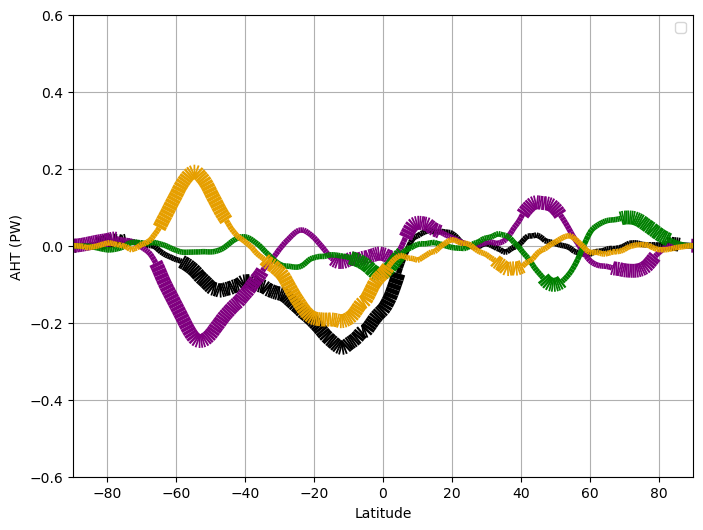

In [637]:
plt.figure(figsize=(8,6))

aht_change = final_ds.sel(time=slice('2009-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('1980-01-01', '1989-12-31')).mean(['time'])

#plt.plot(lats, aht_change.total_aht / 1e15, color='k', lw=5, label='Total AHT')
#plt.plot(lats, aht_change.te_aht / 1e15, color='purple',lw=5, label='TE AHT')
#plt.plot(lats, aht_change.se_aht / 1e15, color='g',lw=5, label='SE AHT')
#plt.plot(lats, aht_change.mmc_aht / 1e15, color='#E69F00',lw=5, label='MMC AHT')

plot_w_line_width(aht_change.total_aht / 1e15, total_mins, total_maxs, 'k')
plot_w_line_width(aht_change.te_aht / 1e15, te_mins, te_maxs, 'purple')
plot_w_line_width(aht_change.se_aht / 1e15, se_mins, se_maxs, 'g')
plot_w_line_width(aht_change.mmc_aht / 1e15, mmc_mins, mmc_maxs, '#E69F00')

#plt.plot(lats, total_maxs, '--', color='k', label='Total AHT')
#plt.plot(lats, total_mins, '--', color='k')
#plt.plot(lats, te_maxs, '--',color='purple', label='TE AHT')
#plt.plot(lats, te_mins, '--',color='purple')
#plt.plot(lats, se_maxs, '--',color='g', label='SE AHT')
#plt.plot(lats, se_mins, '--',color='g')
#plt.plot(lats, mmc_maxs, '--',color='#E69F00', label='MMC AHT')
#plt.plot(lats, mmc_mins, '--',color='#E69F00')

plt.grid()

plt.xlim(-90, 90)
plt.ylim(-0.6, 0.6)

plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/5_24_22_meeting/dry_pot_aht_changes_with_monte_carlo_lwidths_no_bounds')
plt.show()

### Make a Hovmoeller of sorts

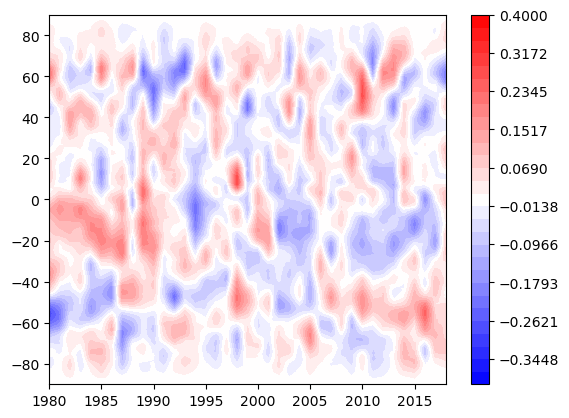

In [603]:
aht_variability = final_ds.groupby('time.year').mean(['time'])

years = range(1980, 2019)
aht_var_anoms = aht_variability - aht_variability.mean(['year'])

plt.contourf(years, lats, aht_var_anoms.mmc_aht.T/1e15, cmap='bwr',
             levels=np.linspace(-0.4, 0.4, 30))

plt.colorbar()

plt.show()

### Ferrel Cell stuff

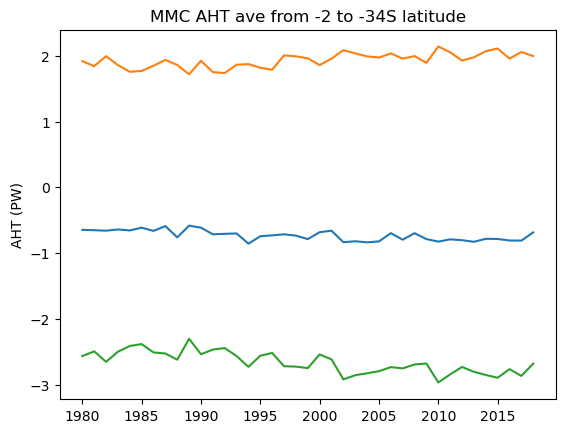

In [735]:
plt.plot(years, aht_variability.mmc_aht.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15,
        label='MMC AHT')
plt.plot(years, aht_variability.mmc_aht_moist.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15,
        label='MMC Moist AHT')
plt.plot(years, aht_variability.mmc_aht_dry_pot.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15,
        label='MMC Dry AHT')

plt.ylabel('AHT (PW)')
plt.title('MMC AHT ave from -2 to -34S latitude')

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_line_plot_-35_-65_lat_yearly_aves')

plt.show()

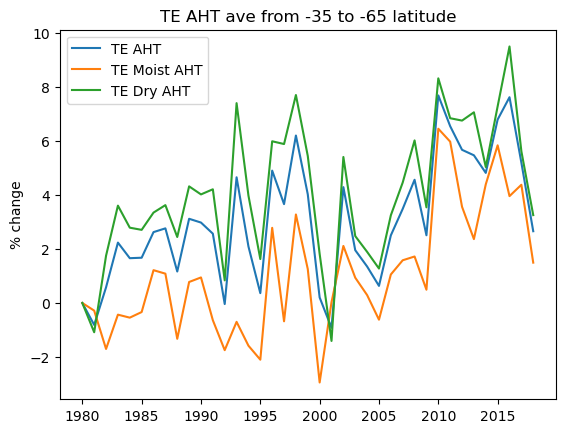

In [736]:
te_aht = aht_variability.te_aht.sel(latitude=slice(-35, -65)).mean(['latitude'])/1e15
te_aht_moist = aht_variability.te_aht_moist.sel(latitude=slice(-35, -65)).mean(['latitude'])/1e15
te_aht_dry_pot = aht_variability.te_aht_dry_pot.sel(latitude=slice(-35, -65)).mean(['latitude'])/1e15
plt.plot(years, 100 * ((te_aht/te_aht[0]) - 1),
        label='TE AHT')
plt.plot(years, 100 * ((te_aht_moist/te_aht_moist[0]) - 1),
        label='TE Moist AHT')
plt.plot(years, 100 * ((te_aht_dry_pot/te_aht_dry_pot[0]) - 1),
        label='TE Dry AHT')

plt.ylabel('% change')
plt.title('TE AHT ave from -35 to -65 latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/te_aht_line_plot_-35_-65_lat__percent_change')

plt.show()

In [737]:
test1_orig = 100
test2_orig = -50

test1_new = test1_orig * 1.15
test2_new = test2_orig * 1.05


aht_test_orig = test1_orig + test2_orig
aht_test_new = test1_new + test2_new

aht_test_change = (aht_test_new - aht_test_orig)/ aht_test_orig

ratio_orig = -test1_orig / test2_orig
ratio_new = -test1_new / test2_new

ratio_change = (ratio_new - ratio_orig) / ratio_orig

print(aht_test_change)
print(ratio_change)

0.24999999999999972
0.09523809523809512


In [738]:
aht_dry_orig = 2
aht_moist_orig = -1

ratio_orig = aht_dry_orig / aht_moist_orig
ratio_final = ratio_orig * 1.1

aht_orig = aht_dry_orig + aht_moist_orig
aht_final

NameError: name 'aht_final' is not defined

In [740]:
aht_subsection = aht_variability.sel(latitude=slice(-35, -65)).mean(['latitude'])/1e15
ferrel_aht = aht_subsection.mmc_aht
ferrel_aht_norm = normalize_time_series(ferrel_aht)
ferrel_aht_no_trend = signal.detrend(ferrel_aht_norm)

ferrel_ratio = -aht_subsection.mmc_aht_dry_pot / aht_subsection.mmc_aht_moist
ferrel_ratio_norm = normalize_time_series(ferrel_ratio)
ferrel_ratio_no_trend = signal.detrend(ferrel_ratio_norm)

eddy_aht = (aht_variability.te_aht + aht_variability.se_aht) / 1e15
eddy_aht_conv = -eddy_aht.differentiate('latitude')
eddy_aht_conv_subset = eddy_aht_conv.sel(latitude=slice(-45, -65)).mean(['latitude'])
eddy_aht_conv_norm = normalize_time_series(eddy_aht_conv_subset)
eddy_aht_conv_no_trend = signal.detrend(eddy_aht_conv_norm)

ferrel_combo_time_series = (ferrel_ratio * eddy_aht_conv_subset)
ferrel_multiplier = np.mean(ferrel_aht.values) / np.mean(ferrel_combo_time_series)
ferrel_combo_time_series = ferrel_combo_time_series * ferrel_multiplier
ferrel_combo_time_series_norm = normalize_time_series(ferrel_combo_time_series)
ferrel_combo_time_series_no_trend = signal.detrend(ferrel_combo_time_series_norm, type='linear')


ferrel_aht_eddy_conv_corr = np.corrcoef(ferrel_aht_no_trend, eddy_aht_conv_no_trend)
ferrel_aht_dry_moist_corr = np.corrcoef(ferrel_aht_no_trend, ferrel_ratio_no_trend)
eddy_conv_dry_moist_corr = np.corrcoef(eddy_aht_conv_no_trend, ferrel_ratio_no_trend)
ferrel_aht_combo_corr = np.corrcoef(ferrel_aht_no_trend, ferrel_combo_time_series_no_trend)

print(ferrel_aht_eddy_conv_corr[0,1])
print(ferrel_aht_dry_moist_corr[0,1])
print(eddy_conv_dry_moist_corr[0,1])
print(ferrel_aht_combo_corr[0,1])


0.4276709604731911
0.49450782031793156
0.0788962413034135
0.5907680990369633


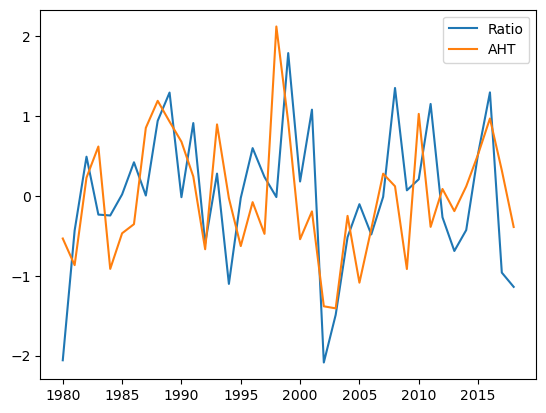

In [741]:
plt.plot(years, ferrel_ratio_no_trend, label='Ratio')
#plt.plot(years, ferrel_combo_time_series_no_trend, label='Combo')
#plt.plot(years, eddy_aht_conv_no_trend, label='Eddy AHT Conv')
plt.plot(years, ferrel_aht_no_trend, label='AHT')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/ferrel_year_to_year_variability_ratio_eddy_aht_conv')

plt.show()

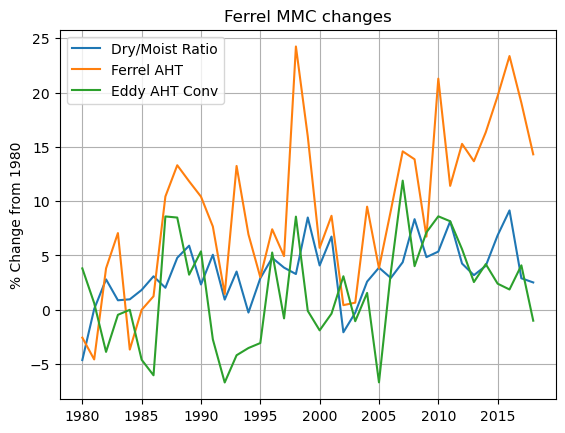

In [744]:

ferrel_ratio_change = 100 * ((ferrel_ratio / np.mean(ferrel_ratio[0:5])) - 1)
plt.plot(years, ferrel_ratio_change, label='Dry/Moist Ratio')

ferrel_aht_change = 100 * ((ferrel_aht / np.mean(ferrel_aht[0:5])) -1)
plt.plot(years, ferrel_aht_change, label='Ferrel AHT')

eddy_conv_change = 100 * ((eddy_aht_conv_subset / np.mean(eddy_aht_conv_subset[0:5])) -1)
plt.plot(years, eddy_conv_change, label='Eddy AHT Conv')

#plt.plot(years, 100 * ((ferrel_combo_time_series/ ferrel_combo_time_series[0]) - 1),
         #label='Both')
plt.ylabel('% Change from 1980')
plt.title('Ferrel MMC changes')

plt.legend(loc=0)

plt.grid()

#plt.savefig('../figures/5_24_22_meeting/ferrel_aht_change_percents_no_combo')

plt.show()

In [661]:
(100 / 50) * 1.02

2.04

### Hadley cell stuff

In [443]:
hadley_strength = pd.read_csv('../hadley_cell_strength_values.csv')

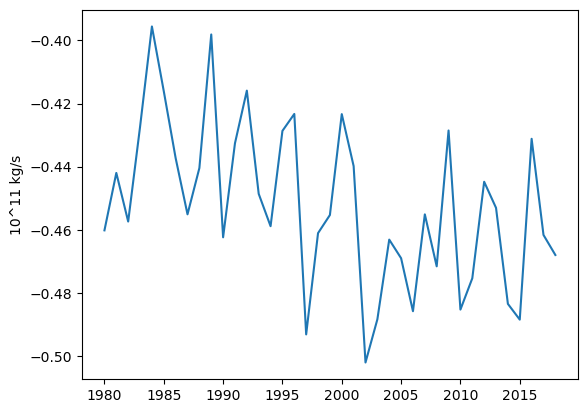

In [734]:
plt.plot(years, hadley_strength['psi_SHC'][1:])

plt.ylabel('10^11 kg/s')
#plt.savefig('../figures/5_24_22_meeting/hadley_cell_sh_mass_transport_time_series')

plt.show()

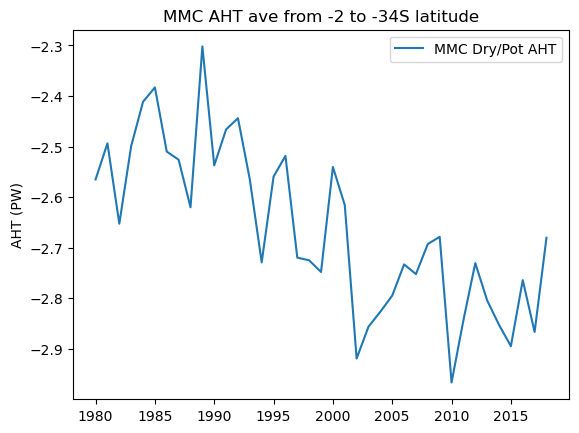

In [709]:
aht_subsection = aht_variability.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15

#plt.plot(years, aht_subsection.mmc_aht,label='MMC AHT')
#plt.plot(years, aht_subsection.mmc_aht_moist,label='MMC Moist AHT')
plt.plot(years, aht_subsection.mmc_aht_dry_pot,label='MMC Dry/Pot AHT')

plt.ylabel('AHT (PW)')
plt.title('MMC AHT ave from -2 to -34S latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_dry_pot_line_plot_-2_-34_lat_yearly_aves')

plt.show()

In [720]:
aht_subsection = aht_variability.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15

dry_moist_ratio = aht_subsection.mmc_aht_dry_pot / aht_subsection.mmc_aht_moist
dry_moist_ratio_norm = normalize_time_series(dry_moist_ratio)
dry_moist_ratio_no_trend = signal.detrend(dry_moist_ratio_norm, type='linear')

mmc_aht = aht_subsection.mmc_aht
mmc_aht_norm = normalize_time_series(mmc_aht)
mmc_aht_no_trend = signal.detrend(mmc_aht_norm, type='linear')

hadley_strength_time_series = hadley_strength['psi_SHC'][1:]
hadley_strength_norm = normalize_time_series(hadley_strength_time_series)
hadley_strength_no_trend = signal.detrend(hadley_strength_norm, type='linear')

combo_time_series = (dry_moist_ratio.values * hadley_strength_time_series.values)
multiplier = np.mean(mmc_aht.values) / np.mean(combo_time_series)
combo_time_series = combo_time_series * multiplier
combo_time_series_norm = normalize_time_series(combo_time_series)
combo_time_series_no_trend = signal.detrend(combo_time_series_norm, type='linear')


#aht_strength_corr = np.corrcoef(mmc_aht_norm, hadley_strength_norm)
#aht_dry_moist_corr = np.corrcoef(mmc_aht_norm, dry_moist_ratio_norm)
#strength_dry_moist_corr = np.corrcoef(hadley_strength_norm, dry_moist_ratio_norm)
#aht_combo_corr = np.corrcoef(mmc_aht_norm, combo_time_series)

aht_strength_corr = np.corrcoef(mmc_aht_no_trend, hadley_strength_no_trend)
aht_dry_moist_corr = np.corrcoef(mmc_aht_no_trend, dry_moist_ratio_no_trend)
strength_dry_moist_corr = np.corrcoef(hadley_strength_no_trend, dry_moist_ratio_no_trend)
aht_combo_corr = np.corrcoef(mmc_aht_no_trend, combo_time_series_no_trend)

print(aht_strength_corr[0,1])
print(aht_dry_moist_corr[0,1])
print(strength_dry_moist_corr[0,1])
print(aht_combo_corr[0,1])

0.22451113401629172
0.8630216885728915
-0.2304652942151288
0.622818255380231


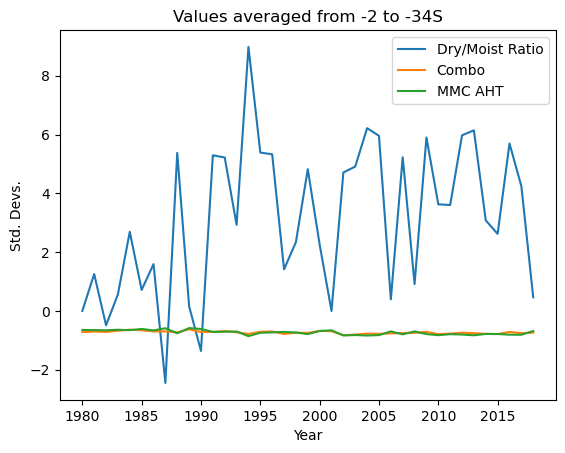

In [721]:
#plt.plot(years, dry_moist_ratio_no_trend, label='Dry moist')
#plt.plot(years, hadley_strength_no_trend, label='Hadley strength')
plt.plot(years, combo_time_series, label='Combo')
plt.plot(years, mmc_aht, label='MMC AHT')

plt.title('Values averaged from -2 to -34S')

plt.xlabel('Year')
plt.ylabel('Std. Devs.')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_combo_time_series_normalized_no_trend')
plt.show()


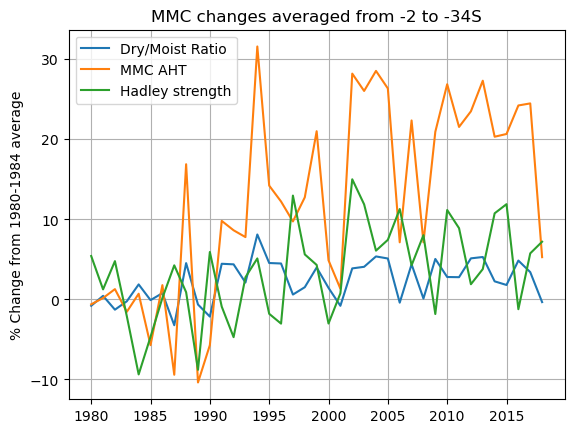

In [732]:

moist_dry_ratio_change = 100 * ((dry_moist_ratio / (np.mean(dry_moist_ratio[0:5]))) - 1)
plt.plot(years, moist_dry_ratio_change, label='Dry/Moist Ratio')

mmc_aht_change = 100 * ((mmc_aht / np.mean(mmc_aht[0:5])) -1)
plt.plot(years, mmc_aht_change, label='MMC AHT')

hadley_strength_change = 100 * ((hadley_strength_time_series / np.mean(hadley_strength_time_series[0:5])) -1)
plt.plot(years, hadley_strength_change, label='Hadley strength')

#plt.plot(years, 100 * ((combo_time_series/ combo_time_series[0]) - 1),
         #label='Both')
plt.ylabel('% Change from 1980-1984 average')
plt.title('MMC changes averaged from -2 to -34S')

plt.legend(loc=0)

plt.grid()

#plt.savefig('../figures/5_24_22_meeting/mmc_ratios_-2_-34S_no_combo')

plt.show()

In [723]:
lin_regress_aht = sc.linregress(years, mmc_aht)
lin_regress_dry_moist = sc.linregress(years, dry_moist_ratio * multiplier)
lin_regress_had_strength = sc.linregress(years, hadley_strength_time_series * multiplier)
lin_regress_combo = sc.linregress(years, combo_time_series)

In [724]:
print('AHT slope: ' + str(lin_regress_aht.slope))
print('Ratio slope: ' + str(lin_regress_dry_moist.slope))
print('Strength slope: ' + str(lin_regress_had_strength.slope))
print('Combo slope: ' + str(lin_regress_combo.slope))

AHT slope: -0.0046104503550499065
Ratio slope: 0.001377847177898674
Strength slope: 0.0012422981737306878
Combo slope: -0.0023223118203358427


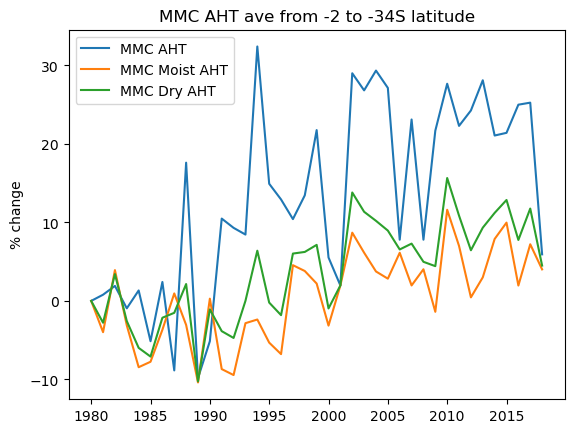

In [725]:
this_aht = aht_variability.mmc_aht.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_moist = aht_variability.mmc_aht_moist.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_dry_pot = aht_variability.mmc_aht_dry_pot.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
plt.plot(years, 100 * ((this_aht/this_aht[0]) - 1),
        label='MMC AHT')
plt.plot(years, 100 * ((this_aht_moist/this_aht_moist[0]) - 1),
        label='MMC Moist AHT')
plt.plot(years, 100 * ((this_aht_dry_pot/this_aht_dry_pot[0]) - 1),
        label='MMC Dry AHT')

plt.ylabel('% change')
plt.title('MMC AHT ave from -2 to -34S latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_line_plot_-2_-34S_lat__percent_change')

plt.show()

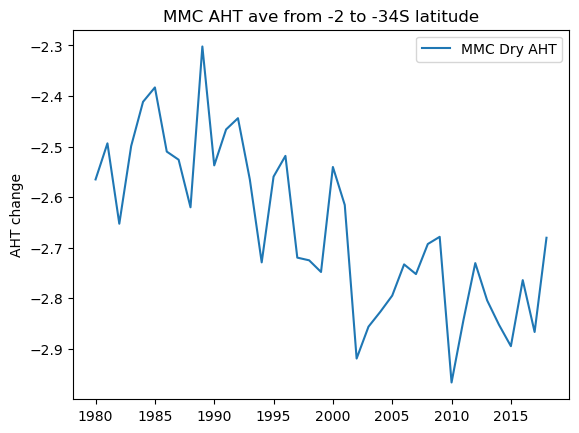

In [726]:
this_aht = aht_variability.mmc_aht.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_moist = aht_variability.mmc_aht_moist.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_dry_pot = aht_variability.mmc_aht_dry_pot.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
#plt.plot(years, this_aht, label='MMC AHT')
#plt.plot(years,this_aht_moist, label='MMC Moist AHT')
plt.plot(years, this_aht_dry_pot, label='MMC Dry AHT')

plt.ylabel('AHT change')
plt.title('MMC AHT ave from -2 to -34S latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/te_aht_line_plot_-35_-65_lat__percent_change')

plt.show()